In [1]:
import os
import pandas as pd

from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
from datetime import datetime

Base = declarative_base()

class Product(Base):
    __tablename__ = "products"

    ProductId = Column(Integer, primary_key=True, index=True)
    Gender = Column(String, index=True)
    Category = Column(String, index=True)
    SubCategory = Column(String, index=True)
    ProductType = Column(String, index=True)
    Colour = Column(String, index=True)
    Usage = Column(String, index=True)
    ProductTitle = Column(String, index=True)
    Image = Column(String)
    ImageURL = Column(String)
    price = Column(Float)
    orders = relationship("OrderItem", back_populates="product")

class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)
    orders = relationship("Order", back_populates="user")

class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    user_id = Column(Integer, ForeignKey("users.id"))
    order_date = Column(DateTime, default=datetime.utcnow)
    total_amount = Column(Float)
    
    user = relationship("User", back_populates="orders")
    items = relationship("OrderItem", back_populates="order")

class OrderItem(Base):
    __tablename__ = "order_items"

    id = Column(Integer, primary_key=True, index=True)
    order_id = Column(Integer, ForeignKey("orders.id"))
    product_id = Column(Integer, ForeignKey("products.ProductId"))
    quantity = Column(Integer, default=1)
    price = Column(Float)

    order = relationship("Order", back_populates="items")
    product = relationship("Product", back_populates="orders")

DATABASE_URL = "sqlite:///example.db"

engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

def init_db():
    Base.metadata.create_all(bind=engine)

    session = SessionLocal()

    users = [
        User(name="Vinci", age=25, email="alice@example.com"),
        User(name="Kuba", age=25, email="bob@example.com"),
        User(name="Wale", age=25, email="charlie@example.com"),
    ]
    session.add_all(users)
    session.commit()

    # Read products from CSV file
    products_df = pd.read_csv(r'C:\Users\ayo\Langgraph-toolkit\fashion.csv')
    products = [
        Product(
            ProductId=row['ProductId'],
            Gender=row['Gender'],
            Category=row['Category'],
            SubCategory=row['SubCategory'],
            ProductType=row['ProductType'],
            Colour=row['Colour'],
            Usage=row['Usage'],
            ProductTitle=row['ProductTitle'],
            Image=row['Image'],
            ImageURL=row['ImageURL'],
            price=row['price']
        )
        for index, row in products_df.iterrows()
    ]
    session.add_all(products)
    session.commit()
    session.close()
    print("The database has been successfully expanded and filled with sample data.")

if __name__ == "__main__":
    if not os.path.exists("example.db"):
        init_db()
    else:
        print("The database already exists.")

C:\Users\ayo\AppData\Local\Temp\ipykernel_3824\969664991.py:9: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


The database has been successfully expanded and filled with sample data.


In [3]:
# sql_agent.py

from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
from langchain_core.runnables.config import RunnableConfig
from dotenv import load_dotenv

load_dotenv()

class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        if table_name in ["products", "orders"]:
            schema += f"Table: {table_name}\n"
            for column in inspector.get_columns(table_name):
                col_name = column["name"]
                col_type = str(column["type"])
                if column.get("primary_key"):
                    col_type += ", Primary Key"
                if column.get("foreign_keys"):
                    fk = list(column["foreign_keys"])[0]
                    col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
                schema += f"- {col_name}: {col_type}\n"
            schema += "\n"
    print("Retrieved database schema.")
    return schema

class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = f"""You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

A question is considered 'relevant' if it meets either of these criteria:
1. It relates to querying or accessing information from the database schema (products, orders, etc.)
2. It involves placing or managing orders

For example:
- "Show me all men's shoes" -> relevant (queries products)
- "Place an order for a red shirt" -> relevant (involves ordering)
- "What's the weather like?" -> not_relevant (unrelated to database or orders)

Respond with only "relevant" or "not_relevant".
"""
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user '{current_user}': {question}")
    
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

The current user is '{current_user}'. For order insertions, follow these steps:
1. First, get the product details using a SELECT query
2. Then, create the order using INSERT
3. Use double quotes for string literals containing apostrophes
4. For product titles, use LIKE with wildcards to make the search more flexible
5. ALWAYS limit results to 5 products using 'LIMIT 5

Example order insertion:
INSERT INTO orders (user_id, order_date, total_amount)
SELECT 
    (SELECT id FROM users WHERE name = "current_user"),
    CURRENT_TIMESTAMP,
    p.price
FROM products p
WHERE p.ProductTitle LIKE "%product_name%";

Then insert the order item:
INSERT INTO order_items (order_id, product_id, quantity, price)
SELECT 
    last_insert_rowid(),
    p.ProductId,
    1,
    p.price
FROM products p
WHERE p.ProductTitle LIKE "%product_name%";

Provide only the SQL queries without any explanations.
""".format(schema=schema, current_user=current_user)
    
    convert_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Question: {question}"),
    ])
    
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    
    # Clean up the SQL query by replacing single quotes with double quotes for product titles
    sql_query = result.sql_query
    if "INSERT INTO orders" in sql_query:
        # Split multiple queries if present
        queries = sql_query.split(';')
        cleaned_queries = []
        for query in queries:
            if query.strip():
                # Replace problematic characters in product titles
                query = query.replace("'%", '"%')
                query = query.replace("%'", '%"')
                cleaned_queries.append(query)
        state["sql_query"] = '; '.join(cleaned_queries)
    else:
        state["sql_query"] = sql_query
        
    print(f"Generated SQL query: {state['sql_query']}")
    return state

def execute_sql(state: AgentState):
    sql_queries = state["sql_query"].strip().split(';')
    session = SessionLocal()
    print(f"Executing SQL queries: {sql_queries}")
    try:
        for query in sql_queries:
            if query.strip():
                result = session.execute(text(query.strip()))
                if query.lower().startswith("select"):
                    rows = result.fetchall()
                    if rows:
                        state["query_rows"] = [dict(zip(result.keys(), row)) for row in rows]
                        state["query_result"] = f"Found {len(rows)} matching products"
                    else:
                        state["query_rows"] = []
                        state["query_result"] = "No results found."
                else:
                    session.commit()
                    state["query_result"] = "Order placed successfully!"
        state["sql_error"] = False
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
        session.rollback()
    finally:
        session.close()
    return state


def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    current_user = state["current_user"]
    query_rows = state.get("query_rows", [])[:5]
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    
    system = """You are an assistant that converts SQL query results into clear, natural language responses for a shopping store. 
    1. Start with a friendly greeting that includes the user's name
    2. For product recommendations: show product title, price, and image URL
    3. For order placement: provide a simple confirmation
    4. For order history: list past orders with dates and amounts
    5. Make the response visually organized and easy to read
    """
    
    if sql_error:
        # Error handling
        generate_prompt = ChatPromptTemplate.from_messages([
            ("system", system),
            ("human", f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear error message, starting with 'Hello {current_user},' and mention that no products were found.""")
        ])
    elif sql.lower().startswith("insert"):
        # Handle order placement confirmation
        generate_prompt = ChatPromptTemplate.from_messages([
            ("system", system),
            ("human", f"""SQL Query:
{sql}

Result:
{result}

Format the response as a simple confirmation:
Hello {current_user}, your order has been successfully placed!""")
        ])
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle no results
            generate_prompt = ChatPromptTemplate.from_messages([
                ("system", system),
                ("human", f"""SQL Query:
{sql}

Result:
{result}

Formulate a message stating no results were found, starting with 'Hello {current_user},'""")
            ])
        elif "orders" in sql.lower():
            # Handle order history display
            formatted_items = [f"Order placed on {row['order_date']} with total amount ${row['total_amount']}" for row in query_rows]
            items_string = "\n".join(formatted_items)
            generate_prompt = ChatPromptTemplate.from_messages([
                ("system", system),
                ("human", f"""SQL Query:
{sql}

Result:
{result}

Format the response as an order history:
Hello {current_user}, here are your recent orders:

{items_string}""")
            ])
        else:
            # Handle product recommendations
            formatted_items = [
                f"{i+1}. {row['ProductTitle']}\n   Price: ${row['price']}\n   Image: {row['ImageURL']}"
                for i, row in enumerate(query_rows[:5])
            ]
            items_string = "\n\n".join(formatted_items)
            total_found = len(state.get("query_rows", []))
            generate_prompt = ChatPromptTemplate.from_messages([
                ("system", system),
                ("human", f"""SQL Query:
{sql}

Result:
{result}

Format the response as product recommendations:
Hello {current_user}, here are 5 recommended products from {total_found} matches:

{items_string}

Would you like to see different products or get more details about any of these items?""")
            ])

    llm = ChatOpenAI(temperature=0)
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")


def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

def irrelevant(state: AgentState):
    print("Generating a response for an irrelevant question.")
    state["query_result"] = "I am sorry I cannot answer your question."
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "irrelevant"

def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("irrelevant", irrelevant)
workflow.add_node("end_max_iterations", end_max_iterations)

workflow.add_edge("get_current_user", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "irrelevant": "irrelevant",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("irrelevant", END)
workflow.add_edge("end_max_iterations", END)

workflow.set_entry_point("get_current_user")

app = workflow.compile()


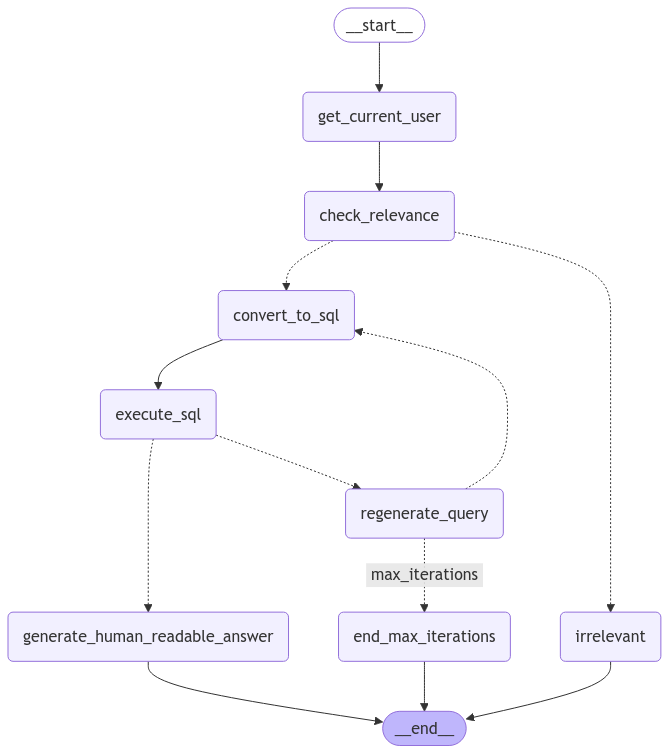

In [4]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [5]:
fake_config = {"configurable": {"current_user_id": "3"}}

In [13]:
user_question_1 = "i want to order the Carlton London Women Stylish Black Flats"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: Wale
Retrieved database schema.
Checking relevance of the question: i want to order the Carlton London Women Stylish Black Flats
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Wale': i want to order the Carlton London Women Stylish Black Flats
Generated SQL query: INSERT INTO orders (user_id, order_date, total_amount)
SELECT 
    (SELECT id FROM users WHERE name = 'Wale'),
    CURRENT_TIMESTAMP,
    p.price
FROM products p
WHERE p.ProductTitle LIKE "%Carlton London Women Stylish Black Flats%"
LIMIT 5; 

INSERT INTO order_items (order_id, product_id, quantity, price)
SELECT 
    last_insert_rowid(),
    p.ProductId,
    1,
    p.price
FROM products p
WHERE p.ProductTitle LIKE "%Carlton London Women Stylish Black Flats%"
LIMIT 5
Executing SQL queries: ['INSERT INTO orders (user_id, order_date, total_amount)\nSELECT \n    (SELECT id FROM users WHERE name = \'Wale\'),\n    CUR

In [14]:
user_question_3 = "show my recent orders"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: Wale
Retrieved database schema.
Checking relevance of the question: show my recent orders
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Wale': show my recent orders
Generated SQL query: SELECT * FROM orders WHERE user_id = (SELECT id FROM users WHERE name = 'Wale') ORDER BY order_date DESC LIMIT 5;
Executing SQL queries: ["SELECT * FROM orders WHERE user_id = (SELECT id FROM users WHERE name = 'Wale') ORDER BY order_date DESC LIMIT 5", '']
Generating a human-readable answer.
Generated human-readable answer.
Result: Hello Wale, here are your recent orders:

1. Order placed on 2024-12-31 01:11:08
   Total amount: $82.05

2. Order placed on 2024-12-31 01:10:32
   Total amount: $82.05


In [7]:
import nest_asyncio
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

nest_asyncio.apply()

app_api = FastAPI()

class Query(BaseModel):
    question: str
    user_id: str

@app_api.post("/query")
async def query_workflow(query: Query):
    try:
        fake_config = {"configurable": {"current_user_id": query.user_id}}
        result = app.invoke(
            {"question": query.question, "attempts": 0}, 
            config=fake_config
        )
        return {"result": result["query_result"]}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app_api, host="0.0.0.0", port=8000)

INFO:     Started server process [3824]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Retrieving the current user based on user ID.
Current user set to: Vinci
Retrieved database schema.
Checking relevance of the question: recommend me footwears for women
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Vinci': recommend me footwears for women
Generated SQL query: SELECT * FROM products WHERE Gender = 'Women' AND Category = 'Footwear' LIMIT 5;
Executing SQL queries: ["SELECT * FROM products WHERE Gender = 'Women' AND Category = 'Footwear' LIMIT 5", '']
Generating a human-readable answer.
Generated human-readable answer.
INFO:     127.0.0.1:53537 - "POST /query HTTP/1.1" 200 OK
Retrieving the current user based on user ID.
Current user set to: Vinci
Retrieved database schema.
Checking relevance of the question: recommend me footwears for women
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Vinci': recommend me footwears for women
Generated SQL query: SELECT * FROM products WHERE 